In [72]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.collections import LineCollection
from scipy.stats import norm

In [73]:
# For 3D plots...
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import interp1d

In [74]:
import PIPPET
import utils

In [75]:
#%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.style.use('default')
  
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.autolayout'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
sns.set_context('paper', font_scale=0.9)

# WIPPET Example

In [83]:
p = PIPPET.PIPPETParams()
p.dt = 0.005
p.overtime = 2*np.pi
p.lambda_0 = 0.001
p.sigma_phi = 0.2
p.mu_0 = np.pi/8
p.V_0 = 0.1
p.eta_mu = 0.00
p.eta_e = 0.0
p.eta_V = 0.00

e_ts = np.array([2*np.pi, 4*np.pi - 1.25])
#e_ts = np.array([2*np.pi, 4*np.pi, 6*np.pi, 8*np.pi, 10*np.pi])
e_means = np.array([0.0,])
e_vars = np.array([0.01,])
e_lams = np.array([0.01,])
p.add(e_ts, e_means, e_vars, e_lams, '')
model = PIPPET.cPIPPET(p)
model.run()

In [95]:
L = list(sorted(model.idx_event))
i = L[0]
j = L[1]
#i = L[3]
#j = L[4]

AssertionError: 

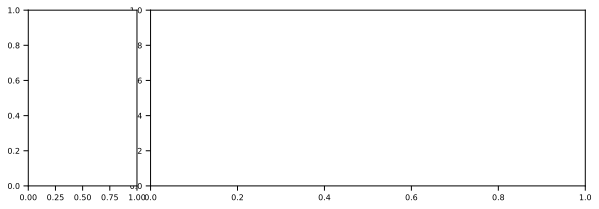

In [98]:
from matplotlib.ticker import FormatStrFormatter

cs = sns.color_palette('husl', 1+model.n_streams)
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("", ["gainsboro","darkgrey"])
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("", ["darkgrey","black"])
cs_e = ['black', 'black']#sns.color_palette('Set1', 2)
cs_segs = sns.color_palette("husl", 3)
cs_segs = [cs_segs[0], cs_segs[-1], cs_segs[1]]

# Create the grid
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 1, hspace=0.1, height_ratios=(2, 4))

gs_t = gs[0].subgridspec(1, 2, width_ratios=(1, 4), wspace=0.05)
gs_p = gs[1].subgridspec(1, 2, width_ratios=(1, 1.5), wspace=0.1)

############## PIPPET-y plot
ax = fig.add_subplot(gs_t[0, 1])
ax_temp = fig.add_subplot(gs_t[0, 0], sharey=ax)

# Phase
def _plot_phase(from_i, to_i, col, offset=0):
    # Phase progress
    std = 2*np.sqrt(model.V_s[from_i:to_i])
    ax.plot(model.ts[from_i:to_i], model.mu_s[from_i:to_i]+offset, c=col, linewidth=1.75)
    ax.fill_between(model.ts[from_i:to_i], model.mu_s[from_i:to_i]+offset-std, model.mu_s[from_i:to_i]+offset+std, alpha=0.2, facecolor=col)

def _plot_phase_wrap(from_i, to_i, col):
    # Find wrapping points
    xs = model.mu_s[from_i:to_i]
    wrap_is = np.where((np.roll(np.sign(xs), 1) != np.sign(xs)) & (np.abs(xs) > 3.1))[0]
    assert wrap_is.size == 1
    wrap_i = wrap_is[0] + from_i
    # Each part
    _plot_phase(from_i, wrap_i, col)
    _plot_phase(from_i, wrap_i, col, offset=-2*np.pi)
    _plot_phase(wrap_i, to_i, col)
    _plot_phase(wrap_i, to_i, col, offset=2*np.pi)
    
_plot_phase_wrap(0, i, cs_segs[0])
_plot_phase_wrap(i, j, cs_segs[1])
_plot_phase_wrap(j, model.ts.size, cs_segs[2])
ax.set_xlabel('Time', fontsize=10, labelpad=10)

#utils.plot_phase(model, ax, 'darkslategrey', xlabelkwargs={'fontsize': 10, 'labelpad': 10})
    
# Stimulus/Auditory events
utils.plot_events(model, ax, ax_temp, cols=cs[1:], stimulus=False, expected=True)
ax.axvline(model.ts[i], color=cs_e[0], alpha=0.75, linestyle='--', linewidth=2, label=r'Event $e_1$')
ax.axvline(model.ts[j], color=cs_e[1], alpha=0.75, linestyle='-.', linewidth=2, label=r'Event $e_2$')
# Template
utils.plot_template(model, ax_temp, ['black'], xlabelkwargs={'fontsize': 10, 'labelpad': 10}, ylabelkwargs={'fontsize': 10})

# Tidying
ax.set_xlim([model.params.t0, model.tmax])
ax.set_ylim([-np.pi, np.pi])
ax.axhline(-np.pi/2, color='grey', alpha=0.33, linestyle='--', linewidth=1)
ax.axhline(np.pi/2, color='grey', alpha=0.33, linestyle='--', linewidth=1)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_temp.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='major', labelsize=8)
ax_temp.tick_params(axis='both', which='major', labelsize=8)

ax_temp.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax_temp.set_yticklabels([r'$-\,\pi$', r'$-\,\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=12)

ax.annotate(r'$t_1$', xy=(5.5, np.pi*.8), fontsize=14, annotation_clip=False)
ax.annotate(r'$t_2$', xy=(10.5, np.pi*.8), fontsize=14, annotation_clip=False)

ax.legend()

############## Polars
ax_b = fig.add_subplot(gs_p[0, 0], projection='polar')


xs_b, ys_b = model.mu_s[:i], np.exp(-model.V_s[:i]/2)
#ax_b.scatter(xs_b, ys_b, s=7, alpha=0.5, color=cs_segs[0])#cmap=cmap1, c=np.arange(xs_b.size))
ax_b.plot(xs_b, ys_b, lw=4, color=cs_segs[0])#cmap=cmap1, c=np.arange(xs_b.size))
xs_b, ys_b = model.mu_s[i:j], np.exp(-model.V_s[i:j]/2)
#ax_b.scatter(xs_b, ys_b, s=7, alpha=0.5, color=cs_segs[1])#cmap=cmap2, c=np.arange(xs_b.size))
ax_b.plot(xs_b, ys_b, lw=4, color=cs_segs[1])#cmap=cmap2, c=np.arange(xs_b.size))
ax_b.plot(model.mu_s[i-1:i+1], np.exp(-model.V_s[i-1:i+1]/2), ls='--', lw=2, c=cs_e[0], alpha=1)

#xs_a, ys_a = model.mu_s[j:], np.exp(-model.V_s[j:]/2)
#ax_b.scatter(xs_a, ys_a, s=7, alpha=0.5, color=cs_segs[2])#cmap=cmap2, c=np.arange(xs_a.size))
#ax_b.plot(xs_a, ys_a, lw=4, color=cs_segs[2])#cmap=cmap2, c=np.arange(xs_a.size))
#ax_b.plot(model.mu_s[j-1:j+1], np.exp(-model.V_s[j-1:j+1]/2), ls='-.', lw=2, c=cs_e[1], alpha=1)


#ax_b.annotate(r'$e_1$', xy=(0 - .66*model.mu_s[i-1:i+1].mean(), np.exp(-model.V_s[i-1:i+1]/2).mean()), fontsize=14, annotation_clip=False)
#ax_b.annotate(r'$e_2$', xy=(1.5* model.mu_s[j-1:j+1].mean(), np.exp(-model.V_s[j-1:j+1]/2).mean()-.05), fontsize=14, annotation_clip=False)
#ax_b.scatter(model.mu_s[0], np.exp(-model.V_s[0]/2), marker='x', s=60, color='black', label='Start')

ax_b.set_theta_offset(0)
ax_b.set_yticks([])

ax_b.grid(linewidth=1, linestyle='-.', color='lightgray', alpha=0.5)
xL = [r'$0$', r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',
           r'$\pm\pi$',r'$-\frac{3\pi}{4}$',r'$-\,\frac{\pi}{2}$',r'$-\,\frac{\pi}{4}$']
ax_b.set_xticklabels(xL, fontsize=12)



#ax_b.annotate('',
#              xytext=(model.mu_s[0], np.exp(-model.V_s[0]/2)*.98), textcoords='data',
##              xy=(model.mu_s[100], np.exp(-model.V_s[100]/2)*.98), xycoords='data',
#              arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", fc="w", lw=1.5),
#              )



############## 3D

def data_for_cylinder_along_z(center_x,center_y,radius,height_z, N=50):
    z = np.linspace(0, height_z, N)
    theta = np.linspace(0, 2*np.pi, N)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid, y_grid, z_grid

ax_3d = fig.add_subplot(gs_p[0, 1], projection='3d')

N = 1000

theta = np.linspace(0, 2 * np.pi, N)
x, y = 10*np.sin(theta), 10*np.cos(theta)
cx = x
cy = y*np.cos(0)+10*np.cos(0)
cz = y*np.sin(0)+10*np.sin(0)
ax_3d.plot(cx, cy, cz, ls='--', c='k')


center_x, center_y = np.median(cx), np.median(cy)

# Cylinder projection of circle
Xc,Yc,Zc = data_for_cylinder_along_z(center_x, center_y, 10, -.1)
ax_3d.plot_surface(Xc, Yc, Zc, alpha=0.25, color='k')

# Map amplitudes to better vector length
amp_map = interp1d([.75,1.2],[0.25,1])

mu_offset = .9*np.pi

mus = np.linspace(-1.5*np.pi, 1.5*np.pi, int(1.5*N))

def _wrapsum(xs, ys):
    wrap_n = int(.25*N)
    xs[-wrap_n:] += ys[:wrap_n]
    xs[:] += ys[wrap_n:-wrap_n]
    xs[:wrap_n] += ys[-wrap_n:]
    return xs

def _arr(x0, y0, x1, y1, k, angle):
    x = (x1 + k*x0)
    y = (k*y1 + (1-k)*y0)
    x -= x1
    y -= y1
    x = x * np.cos(angle) - y * np.sin(angle)
    y = x * np.sin(angle) + y * np.cos(angle)
    x += x1
    y += y1
    ax_3d.plot((x1, x), (y1, y), (0, -0), c='red', lw=3)


# Dist
def _dist(mu, V, c, dalpha=1.0, lalpha=.5, arr=True):
    pdf = norm.pdf(mus, loc=mu, scale=V**0.5)
    amp1 = np.exp(-V/2)
    czpdf = _wrapsum(cz.copy(),pdf)
    ax_3d.plot(cx, cy, czpdf, ls='-', c=c, lw=3, alpha=dalpha)
    peak_i = czpdf.argmax()
    cx_i, cy_i, cz_i = cx[peak_i], cy[peak_i], czpdf.max()
    ax_3d.plot((cx_i, cx_i), (cy_i, cy_i), (0, cz_i), ls='--', c=c, lw=3, alpha=dalpha)

    if arr:
        k = amp_map(amp1)
        end_x = (k*cx_i + (1-k)*center_x)
        end_y = (k*cy_i + (1-k)*center_y)
        ax_3d.plot((center_x, end_x), (center_y, end_y), (0, -0), c=c, lw=3, alpha=1. if not dalpha else dalpha)
        ax_3d.plot((end_x, end_x), (end_y, end_y), (0, -.1), c='k', ls='--', alpha=.5)
        
    return cx_i, cy_i, cz_i

# A
cxy_A1 = _dist(-model.mu_s[i-1]+mu_offset, model.V_s[i-1], cs_segs[0], dalpha=0.3)
cxy_A2 = _dist(-model.mu_s[i]+mu_offset, model.V_s[i], cs_segs[1])
ax_3d.text(cxy_A1[0]-0.2, cxy_A1[1]-0.2, 1.25, r'$e_1$', None, fontsize=12)
# B
cxy_B1 = _dist(-model.mu_s[j-1]+mu_offset, model.V_s[j-1], cs_segs[1], dalpha=0.3)
cxy_B2 = _dist(-model.mu_s[j]+mu_offset, model.V_s[j], cs_segs[2])
interp_half = lambda x, y, k: x + (y-x)/k
ax_3d.text(interp_half(cxy_B1[0], cxy_B2[0], 2), interp_half(cxy_B1[1], cxy_B2[1], 2), 1.25, r'$e_2$', None, fontsize=12)

# Marker in center
ax_3d.scatter([center_x], [center_y], 0, marker='o', color='k', s=50)
ax_3d.plot((center_x, center_x), (center_y, center_y), (0, -.1), color='k')

# View
ax_3d.azim = -80
#ax.dist = 10
#ax.elev = 40

# Hide grid lines
#ax.grid(False)
# Hide axes ticks
ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])
#ax.set_xlabel('x')
#ax.set_ylabel('y')
ax_3d.set_zlabel('Probability Density', fontsize=10)


ax_temp.annotate('A', xy=(0.0, 3.6), fontsize=14, annotation_clip=False)
ax_b.annotate('B', xy=(.75*np.pi, 1.15), fontsize=14, annotation_clip=False)
ax_3d.text2D(0.05, 0.85, 'C', transform=ax_3d.transAxes, fontsize=14)

#fig.savefig('figures/fig_oscpippet.jpeg', bbox_inches='tight');

pass

AssertionError: 

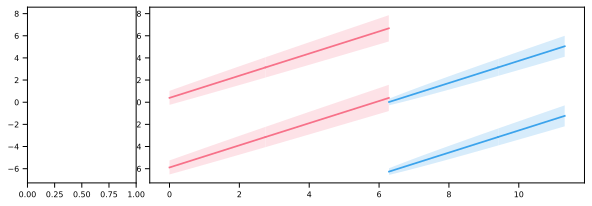

In [79]:
from matplotlib.ticker import FormatStrFormatter

cs = sns.color_palette('husl', 1+model.n_streams)
cmap1 = mpl.colors.LinearSegmentedColormap.from_list("", ["gainsboro","darkgrey"])
cmap2 = mpl.colors.LinearSegmentedColormap.from_list("", ["darkgrey","black"])
cs_e = ['black', 'black']#sns.color_palette('Set1', 2)
cs_segs = sns.color_palette("husl", 3)
cs_segs = [cs_segs[0], cs_segs[-1], cs_segs[1]]

# Create the grid
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 1, hspace=0.1, height_ratios=(2, 4))

gs_t = gs[0].subgridspec(1, 2, width_ratios=(1, 4), wspace=0.05)
gs_p = gs[1].subgridspec(1, 2, width_ratios=(1, 1.5), wspace=0.1)

############## PIPPET-y plot
ax = fig.add_subplot(gs_t[0, 1])
ax_temp = fig.add_subplot(gs_t[0, 0], sharey=ax)

# Phase
def _plot_phase(from_i, to_i, col, offset=0):
    # Phase progress
    std = 2*np.sqrt(model.V_s[from_i:to_i])
    ax.plot(model.ts[from_i:to_i], model.mu_s[from_i:to_i]+offset, c=col, linewidth=1.75)
    ax.fill_between(model.ts[from_i:to_i], model.mu_s[from_i:to_i]+offset-std, model.mu_s[from_i:to_i]+offset+std, alpha=0.2, facecolor=col)

def _plot_phase_wrap(from_i, to_i, col):
    # Find wrapping points
    xs = model.mu_s[from_i:to_i]
    wrap_is = np.where((np.roll(np.sign(xs), 1) != np.sign(xs)) & (np.abs(xs) > 3.1))[0]
    assert wrap_is.size == 1
    wrap_i = wrap_is[0] + from_i
    # Each part
    _plot_phase(from_i, wrap_i, col)
    _plot_phase(from_i, wrap_i, col, offset=-2*np.pi)
    _plot_phase(wrap_i, to_i, col)
    _plot_phase(wrap_i, to_i, col, offset=2*np.pi)
    
_plot_phase_wrap(0, i, cs_segs[0])
_plot_phase_wrap(i, j, cs_segs[1])
_plot_phase_wrap(j, model.ts.size, cs_segs[2])
ax.set_xlabel('Time', fontsize=10, labelpad=10)

#utils.plot_phase(model, ax, 'darkslategrey', xlabelkwargs={'fontsize': 10, 'labelpad': 10})
    
# Stimulus/Auditory events
utils.plot_events(model, ax, ax_temp, cols=cs[1:], stimulus=False, expected=True)
ax.axvline(model.ts[i], color=cs_e[0], alpha=0.75, linestyle='--', linewidth=2, label=r'Event $e_1$')
ax.axvline(model.ts[j], color=cs_e[1], alpha=0.75, linestyle='-.', linewidth=2, label=r'Event $e_2$')
# Template
utils.plot_template(model, ax_temp, ['black'], xlabelkwargs={'fontsize': 10, 'labelpad': 10}, ylabelkwargs={'fontsize': 10})

# Tidying
ax.set_xlim([model.params.t0, model.tmax])
ax.set_ylim([-np.pi, np.pi])
ax.axhline(-np.pi/2, color='grey', alpha=0.33, linestyle='--', linewidth=1)
ax.axhline(np.pi/2, color='grey', alpha=0.33, linestyle='--', linewidth=1)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_temp.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.setp(ax.get_yticklabels(), visible=False)
ax.tick_params(axis='both', which='major', labelsize=8)
ax_temp.tick_params(axis='both', which='major', labelsize=8)

ax_temp.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax_temp.set_yticklabels([r'$-\,\pi$', r'$-\,\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=12)

ax.annotate(r'$t_1$', xy=(5.5, np.pi*.8), fontsize=14, annotation_clip=False)
ax.annotate(r'$t_2$', xy=(10.5, np.pi*.8), fontsize=14, annotation_clip=False)

ax.legend()

############## Polars
ax_b = fig.add_subplot(gs_p[0, 0], projection='polar')


xs_b, ys_b = model.mu_s[:i], np.exp(-model.V_s[:i]/2)
#ax_b.scatter(xs_b, ys_b, s=7, alpha=0.5, color=cs_segs[0])#cmap=cmap1, c=np.arange(xs_b.size))
ax_b.plot(xs_b, ys_b, lw=4, color=cs_segs[0])#cmap=cmap1, c=np.arange(xs_b.size))
xs_b, ys_b = model.mu_s[i:j], np.exp(-model.V_s[i:j]/2)
#ax_b.scatter(xs_b, ys_b, s=7, alpha=0.5, color=cs_segs[1])#cmap=cmap2, c=np.arange(xs_b.size))
ax_b.plot(xs_b, ys_b, lw=4, color=cs_segs[1])#cmap=cmap2, c=np.arange(xs_b.size))
ax_b.plot(model.mu_s[i-1:i+1], np.exp(-model.V_s[i-1:i+1]/2), ls='--', lw=2, c=cs_e[0], alpha=1)

xs_a, ys_a = model.mu_s[j:], np.exp(-model.V_s[j:]/2)
#ax_b.scatter(xs_a, ys_a, s=7, alpha=0.5, color=cs_segs[2])#cmap=cmap2, c=np.arange(xs_a.size))
ax_b.plot(xs_a, ys_a, lw=4, color=cs_segs[2])#cmap=cmap2, c=np.arange(xs_a.size))
ax_b.plot(model.mu_s[j-1:j+1], np.exp(-model.V_s[j-1:j+1]/2), ls='-.', lw=2, c=cs_e[1], alpha=1)


ax_b.annotate(r'$e_1$', xy=(0 - .66*model.mu_s[i-1:i+1].mean(), np.exp(-model.V_s[i-1:i+1]/2).mean()), fontsize=14, annotation_clip=False)
ax_b.annotate(r'$e_2$', xy=(1.5* model.mu_s[j-1:j+1].mean(), np.exp(-model.V_s[j-1:j+1]/2).mean()-.05), fontsize=14, annotation_clip=False)
#ax_b.scatter(model.mu_s[0], np.exp(-model.V_s[0]/2), marker='x', s=60, color='black', label='Start')

ax_b.set_theta_offset(0)
ax_b.set_yticks([])

ax_b.grid(linewidth=1, linestyle='-.', color='lightgray', alpha=0.5)
xL = [r'$0$', r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',
           r'$\pm\pi$',r'$-\frac{3\pi}{4}$',r'$-\,\frac{\pi}{2}$',r'$-\,\frac{\pi}{4}$']
ax_b.set_xticklabels(xL, fontsize=12)



ax_b.annotate('',
              xytext=(model.mu_s[0], np.exp(-model.V_s[0]/2)*.98), textcoords='data',
              xy=(model.mu_s[100], np.exp(-model.V_s[100]/2)*.98), xycoords='data',
              arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", fc="w", lw=1.5),
              )



############## 3D

def data_for_cylinder_along_z(center_x,center_y,radius,height_z, N=50):
    z = np.linspace(0, height_z, N)
    theta = np.linspace(0, 2*np.pi, N)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid, y_grid, z_grid

ax_3d = fig.add_subplot(gs_p[0, 1], projection='3d')

N = 1000

theta = np.linspace(0, 2 * np.pi, N)
x, y = 10*np.sin(theta), 10*np.cos(theta)
cx = x
cy = y*np.cos(0)+10*np.cos(0)
cz = y*np.sin(0)+10*np.sin(0)
ax_3d.plot(cx, cy, cz, ls='--', c='k')


center_x, center_y = np.median(cx), np.median(cy)

# Cylinder projection of circle
Xc,Yc,Zc = data_for_cylinder_along_z(center_x, center_y, 10, -.1)
ax_3d.plot_surface(Xc, Yc, Zc, alpha=0.25, color='k')

# Map amplitudes to better vector length
amp_map = interp1d([.75,1.2],[0.25,1])

mu_offset = np.pi

mus = np.linspace(-1.5*np.pi, 1.5*np.pi, int(1.5*N))

def _wrapsum(xs, ys):
    wrap_n = int(.25*N)
    xs[-wrap_n:] += ys[:wrap_n]
    xs[:] += ys[wrap_n:-wrap_n]
    xs[:wrap_n] += ys[-wrap_n:]
    return xs

def _arr(x0, y0, x1, y1, k, angle):
    x = (x1 + k*x0)
    y = (k*y1 + (1-k)*y0)
    x -= x1
    y -= y1
    x = x * np.cos(angle) - y * np.sin(angle)
    y = x * np.sin(angle) + y * np.cos(angle)
    x += x1
    y += y1
    ax_3d.plot((x1, x), (y1, y), (0, -0), c='red', lw=3)


# Dist
def _dist(mu, V, c, dalpha=1.0, lalpha=.5, arr=True):
    pdf = norm.pdf(mus, loc=mu, scale=V**0.5)
    amp1 = np.exp(-V/2)
    czpdf = _wrapsum(cz.copy(),pdf)
    ax_3d.plot(cx, cy, czpdf, ls='-', c=c, lw=3, alpha=dalpha)
    peak_i = czpdf.argmax()
    cx_i, cy_i, cz_i = cx[peak_i], cy[peak_i], czpdf.max()
    ax_3d.plot((cx_i, cx_i), (cy_i, cy_i), (0, cz_i), ls='--', c=c, lw=3, alpha=dalpha)

    if arr:
        k = amp_map(amp1)
        end_x = (k*cx_i + (1-k)*center_x)
        end_y = (k*cy_i + (1-k)*center_y)
        ax_3d.plot((center_x, end_x), (center_y, end_y), (0, -0), c=c, lw=3, alpha=1. if not dalpha else dalpha)
        ax_3d.plot((end_x, end_x), (end_y, end_y), (0, -.1), c='k', ls='--', alpha=.5)
        
    return cx_i, cy_i, cz_i

# A
cxy_A1 = _dist(-model.mu_s[i-1]+mu_offset, model.V_s[i-1], cs_segs[0])#, dalpha=0.3)
cxy_A2 = _dist(-model.mu_s[i]+mu_offset, model.V_s[i], cs_segs[1])
ax_3d.text(cxy_A1[0]-4, cxy_A1[1]-2.5, 1.25, r'$p_{t_{1}}(\phi)$', None, fontsize=12)
ax_3d.text(cxy_A1[0]+6, cxy_A1[1]+5, 1.25, r'$p_{t_{1}+}(\phi)$', None, fontsize=12)

# Marker in center
ax_3d.scatter([center_x], [center_y], 0, marker='o', color='k', s=50)
ax_3d.plot((center_x, center_x), (center_y, center_y), (0, -.1), color='k')
ax_3d.text(center_x+1.25, center_y, 0.35, r'$z_{t_{1}+}$', None, fontsize=12)
ax_3d.text(center_x-2.75, center_y, 0.1, r'$z_{t_{1}}$', None, fontsize=12)

# View
ax_3d.azim = -80
#ax.dist = 10
#ax.elev = 40

# Hide grid lines
#ax.grid(False)
# Hide axes ticks
ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])
#ax.set_xlabel('x')
#ax.set_ylabel('y')
ax_3d.set_zlabel('Probability Density', fontsize=10)


ax_temp.annotate('A', xy=(0.0, 3.6), fontsize=14, annotation_clip=False)
ax_b.annotate('B', xy=(.75*np.pi, 1.15), fontsize=14, annotation_clip=False)
ax_3d.text2D(0.05, 0.85, 'C', transform=ax_3d.transAxes, fontsize=14)

fig.savefig('figures/fig_cpippet.jpeg', bbox_inches='tight');

pass

# Resetting

In [59]:
def _polarpoints(n_rad, n_theta):
    dr = 1/n_rad
    r_dis = np.arange(dr, 1, dr)
    
    dtheta = 2*np.pi/n_theta
    theta_dis = np.arange(0, 2*np.pi, dtheta)

    x_dis = []
    y_dis = []
    R_dis = []
    Theta_dis = []
    for i in range(0, r_dis.size):
        for j in range(0, theta_dis.size):
            x_dis.append(r_dis[i] * np.cos(theta_dis[j]))
            y_dis.append(r_dis[i] * np.sin(theta_dis[j]))
            R_dis.append(r_dis[i])
            Theta_dis.append(theta_dis[j])
    
    return np.vstack((x_dis, y_dis, R_dis, Theta_dis)).T

n_r = 12
n_th = 24
x_y_r_th = _polarpoints(n_r, n_th)

In [60]:
p = PIPPET.PIPPETParams()
p.dt = 0.001
p.overtime = p.dt
p.lambda_0 = 0.1
p.sigma_phi = 0.2
p.mu_0 = 0 #model.mu_s[sorted(model.idx_event)[0]-1]
p.V_0 = 0.1 #model.V_s[sorted(model.idx_event)[0]-1]
p.eta_mu = 0.00
p.eta_e = 0.0
p.eta_V = 0.00

p_0 = copy.deepcopy(p)
e_ts = np.array([0.0])
e_vars = np.array([0.01])
e_lams = np.array([0.1])
p_0.add(e_ts, np.array([0.0]), e_vars, e_lams, '')
model_0 = PIPPET.cPIPPET(p_0)

p_0_pi = copy.deepcopy(p)
p_0_pi.add(e_ts, np.array([0.0, np.pi]), np.array([0.01, 0.01]), np.array([0.1, 0.1]), '')
model_0_pi = PIPPET.cPIPPET(p_0_pi)

In [61]:
zs = x_y_r_th[:, 2] * np.exp(1j*x_y_r_th[:, 3])
Vs = -2 * np.log(x_y_r_th[:, 2])
mus = x_y_r_th[:, 3]

def _z_hats(m):
    z_hats = []
    for mu, V in zip(mus, Vs):
        blambda = m.streams[0].zlambda(mu, V, m.params.tau)
        z_hats.append(m.streams[0].z_hat(mu, V, blambda, m.params.tau))
    z_hats = np.array(z_hats)
    z_hats_x = np.real(z_hats)
    z_hats_y = np.imag(z_hats)
    return z_hats, z_hats_x, z_hats_y

z_hats_0, z_hats_x_0, z_hats_y_0 = _z_hats(model_0)
z_hats_0_pi, z_hats_x_0_pi, z_hats_y_0_pi = _z_hats(model_0_pi)

In [62]:
def _exp(mus, stream):
    gauss = None
    for e_lam, e_mean, e_var in zip(stream.params.e_lambdas, stream.params.e_means, stream.params.e_vars):
        if gauss is None:
            gauss = e_lam*norm.pdf(mus, loc=e_mean, scale=e_var**0.5)
        else:
            gauss += e_lam*norm.pdf(mus, loc=e_mean, scale=e_var**0.5)
    return gauss

thetas = np.linspace(0, 2*np.pi, z_hats_0.size)
thetas_wrap = np.linspace(-np.pi, np.pi, z_hats_0.size)
thetas_wrap = np.roll(thetas_wrap, thetas_wrap.size//2)
thetas_full = np.concatenate((np.linspace(0, np.pi, z_hats_0.size//2), np.linspace(np.pi, 0, z_hats_0.size//2)))

lambdas_0 = _exp(thetas_wrap, model_0.streams[0])
lambdas_0_pi = _exp(thetas_full, model_0_pi.streams[0])

In [63]:
cs = ['k',]
cs_cont = sns.color_palette('viridis', x_y_r_th.shape[0])

TODO

/var/folders/ql/bnsc85g513n0k8yvttws51ym0000gn/T/ipykernel_98677/2072310190.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


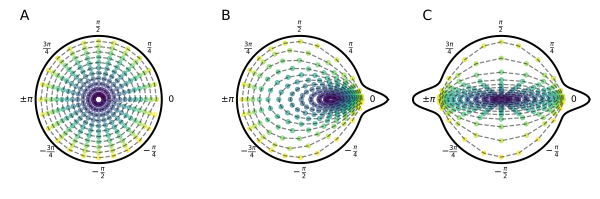

In [64]:
fig = plt.figure(figsize=(10.5, 3.33))
gs = fig.add_gridspec(1, 3, hspace=0.1, width_ratios=(1, 1, 1))

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

####
# Unit circle
ax0.plot(np.cos(thetas), np.sin(thetas), color=cs[0], ls='-', lw=2, alpha=0.99)

#Initial
for i in range(n_r):
    from_i, to_i = i*n_th, (i+1)*n_th
    ax0.plot(x_y_r_th[from_i:to_i+1, 0], x_y_r_th[from_i:to_i+1, 1], c='k', ls='--', alpha=0.5)

ax0.scatter(x_y_r_th[:, 0], x_y_r_th[:, 1], marker='o', s=20, alpha=0.6, color=cs_cont)

####

for i in range(n_r+1):
    from_i, to_i = i*n_th, (i+1)*n_th
    ax1.plot(z_hats_x_0[from_i:to_i+1], z_hats_y_0[from_i:to_i+1], c='k', ls='--', alpha=0.5)

ax1.scatter(z_hats_x_0, z_hats_y_0, marker='o', s=20, alpha=0.6, color=cs_cont)

# Expectations
ax1.plot((lambdas_0 + 1) * np.cos(thetas), (lambdas_0 + 1) * np.sin(thetas), color=cs[0], lw=2, alpha=0.99)

####

for i in range(n_r+1):
    from_i, to_i = i*n_th, (i+1)*n_th
    ax2.plot(z_hats_x_0_pi[from_i:to_i+1], z_hats_y_0_pi[from_i:to_i+1], c='k', ls='--', alpha=0.5)

ax2.scatter(z_hats_x_0_pi, z_hats_y_0_pi, marker='o', s=20, alpha=0.6, color=cs_cont)

# Expectations
ax2.plot((lambdas_0_pi + 1) * np.cos(thetas), (lambdas_0_pi + 1) * np.sin(thetas), color=cs[0], lw=2, alpha=0.99)



#x_hat_dis = real(z_hat_dis);
#y_hat_dis = imag(z_hat_dis);

theta_labels = ((0, r'0.0', ))


theta_tick = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4]
xL = [r'$0$', r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',
           r'$\pm\pi$',r'$-\frac{3\pi}{4}$',r'$-\,\frac{\pi}{2}$',r'$-\,\frac{\pi}{4}$']

k = 1.15
for theta, label in zip(theta_tick, xL):
    for ax in (ax0, ax1, ax2):
        ax.text(k*np.cos(theta), k*np.sin(theta), label, fontsize=9,
                horizontalalignment='center', verticalalignment='center')

v = 1.45
for ax in (ax0, ax1, ax2):
    ax.set_xlim([-v, v])
    ax.set_ylim([-v, v])
    ax.axis('off')
    
#ax1.legend()


ax0.annotate('A', xy=(-1.25, 1.25), fontsize=14, annotation_clip=False)
ax1.annotate('B', xy=(-1.25, 1.25), fontsize=14, annotation_clip=False)
ax2.annotate('C', xy=(-1.25, 1.25), fontsize=14, annotation_clip=False)

fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0)
    
'''
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(x_y_r_th[:,3], x_y_r_th[:,2])
plt.show()
''';


fig.savefig('figures/fig_cpippet_reset.pdf', bbox_inches='tight');

# gradWIPPET Example

In [15]:
from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.interpolate import splrep, splev

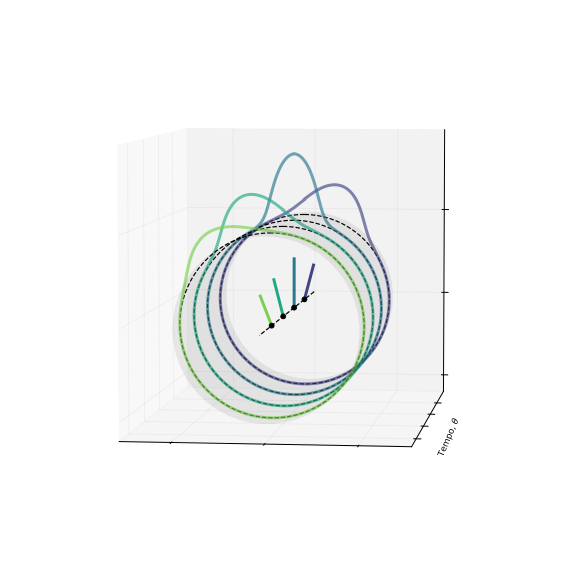

In [16]:
fig = plt.figure(figsize=(10, 10))
ax_3d = fig.add_subplot(projection='3d')

# Unit circles
xy_N = 1000
theta = np.linspace(0, 2 * np.pi, xy_N)

# Dists
mus = np.linspace(0.4, 0.7, 4)*np.pi
Vs = [0.06, 0.025, 0.06, 0.08]
lambdas = [.5, .6, .5, .3]
grad_N = len(mus)

# For scaling vectors
amp_map = interp1d([.925, 1],[0.05,.66])

cs = sns.color_palette('viridis', len(mus))

# def _wrapsum_flat(xs, ys, N=xy_N):
#     wrap_n = int(.125*N)
#     xs[-wrap_n:] += ys[:wrap_n]
#     xs[:] += ys[wrap_n:-wrap_n]
#     xs[:wrap_n] += ys[-wrap_n:]
#     return xs

pdfs = []
for i, (mu, V, lam) in enumerate(zip(mus, Vs, lambdas)):
    
    # Ref unit circle
    x, y = np.sin(theta), np.cos(theta)
    cx = x
    cy = y
    cz = np.ones(cy.shape)*i
    ax_3d.plot(cx, cz, cy, ls='--', c='k')
    
    # Wrapped dist
    #mus_grid = np.linspace(-1.25*np.pi, 1.25*np.pi, int(1.25*xy_N))
    mus_grid = np.linspace(-np.pi, np.pi, xy_N)
    pdf = 0.5*lam*norm.pdf(mus_grid, loc=mu, scale=V**0.5)
    pdfs.append(pdf)
    #rad = 1 + _wrapsum_flat(np.zeros(x.shape), pdf)
    rad = 1 + pdf
    rad = np.roll(rad, xy_N//4)

    # Plot
    x, y = rad*np.sin(theta), rad*np.cos(theta)
    # Note: this smoothing is cursed, please forgive me
#     from_smooth, to_smooth = -5, 5
#     for j in np.arange(from_smooth, to_smooth+1):
#         x[j] = np.linspace(x[from_smooth], x[to_smooth], to_smooth-from_smooth)[j]
#         y[j] = np.linspace(y[from_smooth], y[to_smooth], to_smooth-from_smooth)[j]
    cx_pdf = x
    cy_pdf = y
    cz_pdf = np.ones(cy_pdf.shape)*i
    ax_3d.plot(cx_pdf, cz_pdf, cy_pdf, ls='-', lw=3, alpha=0.65, c=cs[i])
    
    # Vector-ish line
    cx_i, cy_i = cx[cy_pdf.argmax()], cy[cy_pdf.argmax()]
    k =  amp_map(np.exp(-V/2))
    end_x = k*cx_i
    end_y = k*cy_i
    ax_3d.plot((0, end_x), (i, i), (0, end_y), c=cs[i], lw=3, alpha=1.)

    # Center marker
    ax_3d.scatter([0], cz_pdf[0], [0], marker='o', color='k', s=25)
    

# Reference cylinder
zs = np.linspace(-1, len(mus), 10)
xys = np.zeros(zs.size)
ax_3d.plot(xys, zs, xys, color='k', ls='--')
# Reference cylinder
Xc,Yc,Zc = data_for_cylinder_along_z(0, 0, 1, len(mus))
ax_3d.plot_surface(Xc, Zc-.5, Yc, alpha=0.075, color='k')

# ax_3d.set_xlabel('x')
# ax_3d.set_ylabel('y')
# ax_3d.set_zlabel('z')
ax_3d.set_xlabel(r'')
ax_3d.yaxis.set_rotate_label(False)
ax_3d.set_ylabel(r'Tempo, $\theta$', labelpad=0, rotation=67)
ax_3d.set_zlabel(r'')

# ax_3d.set_xticks([])
# ax_3d.set_xticks([], minor=True)
# ax_3d.set_yticks([])
# ax_3d.set_yticks([], minor=True)
# ax_3d.set_zticks([])
# ax_3d.set_zticks([], minor=True)

ax_3d.set_xticks([-1, 0, 1])
ax_3d.set_yticks([0, 1, 2, 3])
ax_3d.set_zticks([-1, 0, 1])

ax_3d.set_xticklabels([])
ax_3d.set_yticklabels([])
ax_3d.set_zticklabels([])

ax_3d.view_init(elev=5, azim=97)# good view
#ax_3d.view_init(elev=0, azim=90) # facing on
#ax_3d.view_init(elev=0, azim=0) # facing side

#ax_3d.set_xlim([vmin, vmax])
ax_3d.set_ylim([-1, 3.5])
ax_3d.set_xlim([-1.5, 1.5])
ax_3d.set_zlim([None, None])

limits = np.array([getattr(ax_3d, f'get_{axis}lim')() for axis in 'xyz'])
ax_3d.set_box_aspect(np.ptp(limits, axis=1))


fig.savefig('figures/fig_cpatippet.jpeg', bbox_inches='tight');

pass

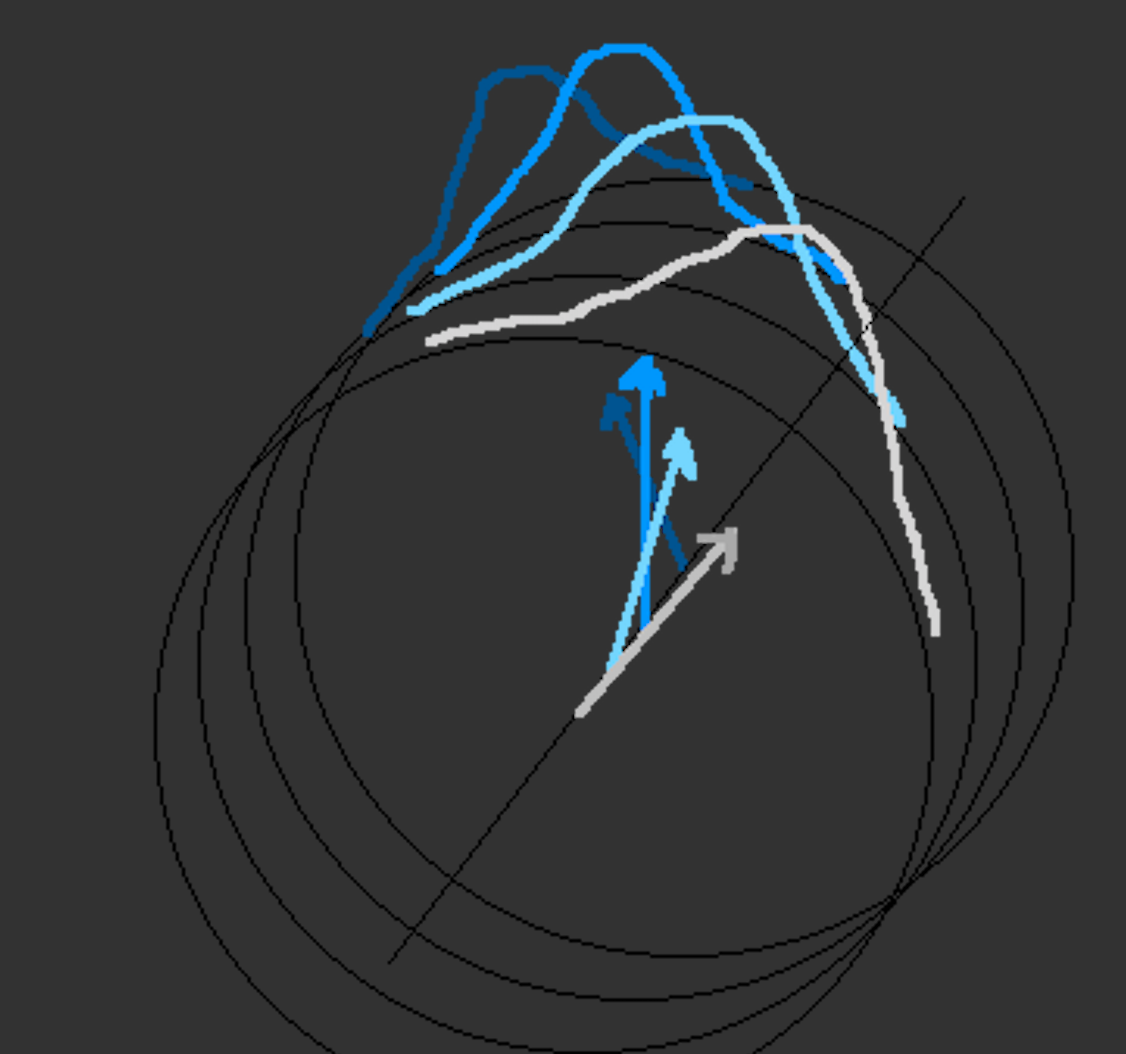